In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from hydra import initialize, compose
from ergochemics.draw import draw_molecule
from IPython.display import display, SVG


with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

# log(y) = mx + b
# y = 10^(mx + b) = 10^b * 10^(mx)
def line_of_best_fit(x, fit):
    m, b = fit
    return 10**b * 10**(m * x)

plt.rcParams.update({
    "font.size": 14,
    "axes.labelsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12,
    "axes.titlesize": 16,
})

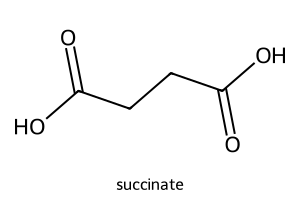

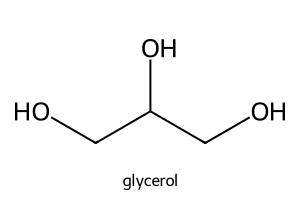

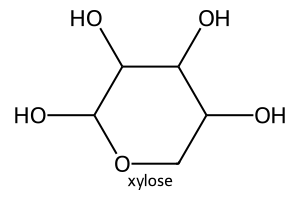

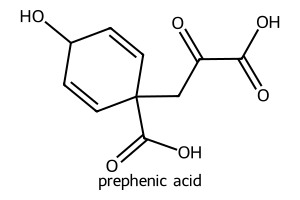

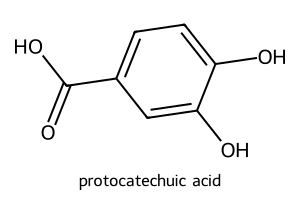

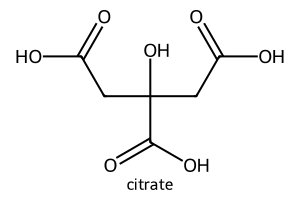

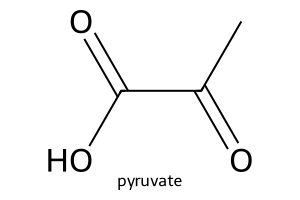

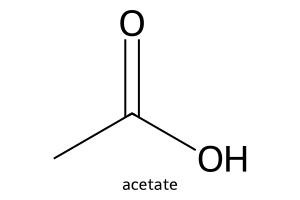

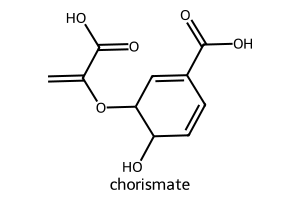

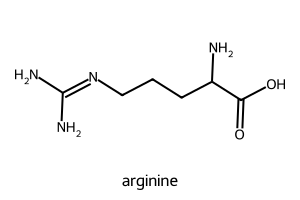

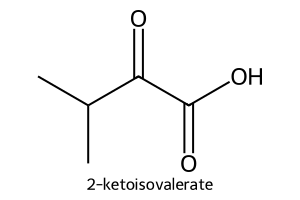

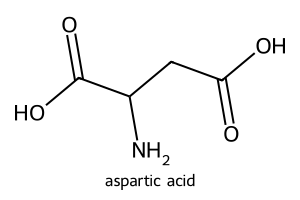

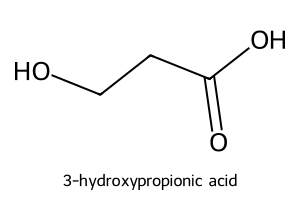

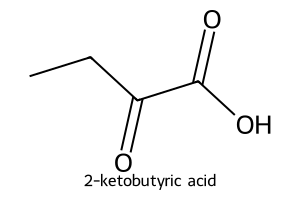

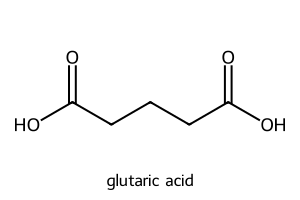

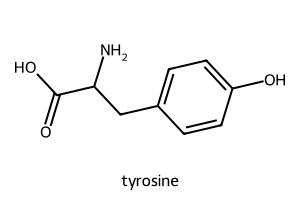

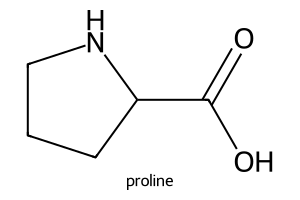

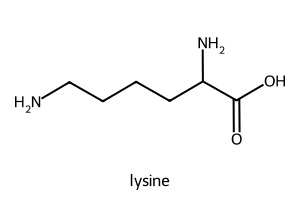

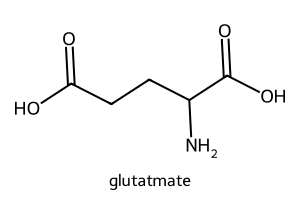

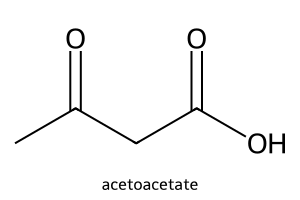

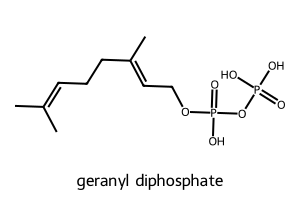

In [23]:
starters_name = "250728_benchmark_starters"

starters = pd.read_csv(Path(cfg.artifacts) / "starters" / f"{starters_name}.csv")
starters.id = starters.id.str.replace(r'(\d)_', r'\1-', regex=True)
starters.id = starters.id.str.replace('_', ' ')
starters.id = starters.id.str.lower()
for _, row in starters.iterrows():
    smi = row.smiles
    name = row.id
    img = draw_molecule(smi, draw_options={"useBWAtomPalette": None}, size=(300, 200), legend=name)
    display(SVG(img))
    
    with open(Path(cfg.figures) / "test_expansion_starters" / f"{name.replace(' ', '_')}.svg", 'w') as f:
        f.write(img)


In [17]:
expansion_name = f"2_steps_{starters_name}"
a_plus_b = True
rule_sets = [

    'mechinformed',
    'mechinferred_dt_956',
    'mechinferred_dt_224',
    'mechinferred_dt_112',
    'mechinferred_dt_039',
    'mechinferred_dt_019',
    'rc_plus_0',
    'rc_plus_1',
    'rc_plus_2',
    'rc_plus_3',
    'rc_plus_4',
    'imt',
    'rdchiral',
]

dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*compound_metrics.parquet"):
    rule_set = str(p.stem).split("_rules_")[1]
    if rule_set not in rule_sets:
        continue
    df = pd.read_parquet(p)
    dfes.append(df)

cpd_df = pd.concat(dfes, ignore_index=True)
cpd_df['expansion'] = cpd_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
cpd_df = cpd_df.groupby(["expansion", "gen"]).agg({"fan_out": ["mean", "std"]}).reset_index()
cpd_df.head()

expansion gen      fan_out  \
                                                                 mean   
0  2_steps_250728_benchmark_starters_rules_imt_ru...   0  4441.238095   
1  2_steps_250728_benchmark_starters_rules_imt_ru...   1   770.442600   
2  2_steps_250728_benchmark_starters_rules_mechin...   0   164.714286   
3  2_steps_250728_benchmark_starters_rules_mechin...   1    49.034743   
4  2_steps_250728_benchmark_starters_rules_mechin...   0   326.809524   

                
           std  
0  8316.820065  
1   608.862718  
2   193.730778  
3    30.934223  
4   379.017627

In [4]:
known_reactions = {}

for exp_name in cpd_df["expansion"].unique():
    rule_set = exp_name.split("_rules_")[1]
    fn = Path(cfg.raw_data) / f"mapped_known_reactions_x_{rule_set}_rules.parquet"
    print(fn)
    mapped_rxns = pd.read_parquet(fn)
    rxns = set(mapped_rxns["smarts"])
    known_reactions[exp_name] = rxns
    del mapped_rxns

/home/stef/cgr/data/raw/mapped_known_reactions_x_imt_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_019_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_039_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_112_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_224_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinferred_dt_956_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_mechinformed_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_0_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_1_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_2_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_3_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rc_plus_4_rules.parquet
/home/stef/cgr/data/raw/mapped_known_reactions_x_rdchiral_rules.parquet


In [5]:
ds = 10
dfes = []
for p in Path(cfg.processed_data).glob(f"*{expansion_name}*aplusb_{a_plus_b}*reaction_metrics.parquet"):
    rule_set = str(p.stem).split("_rules_")[1]
    if rule_set not in rule_sets:
        continue
    
    if "batch" in str(p):
        print(p)
        if int(str(p).split("_")[1]) % ds != 0:
            continue
    
    df = pd.read_parquet(p)
    dfes.append(df)

rxn_df = pd.concat(dfes, ignore_index=True)
del dfes, df
rxn_df['expansion'] = rxn_df['expansion'].str.replace(
    r'^batch_\d+_of_20_', '', regex=True
)
print(len(rxn_df))
rxn_df["known"] = rxn_df.apply(
    lambda row: row["smarts"] in known_reactions[row["expansion"]],
    axis=1
)
rxn_df = rxn_df[~rxn_df["known"]]
rxn_df = rxn_df.explode("rules")
rxn_df['rules'] = rxn_df['rules'].apply(lambda x : x.split('_')[0])
rxn_df['rules'] = rxn_df.apply(lambda row : f"{row['expansion'].split('_rules_')[1]}_rule_{row['rules']}", axis=1)
print(len(rxn_df))
rxn_df.head()

/home/stef/cgr/data/processed/batch_19_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_2_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_6_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_16_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_0_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_1_of_20_2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk_reaction_metrics.parquet
/home/stef/cgr/data/processed/batch_14_of_20_2_steps_250728_benchmark_star

,id,smarts,am_smarts,dxgb_label,max_rxn_sim,nearest_analogue,nearest_analogue_id,rules,expansion,known
0,R35e196dd0cbbbb3e8e9d0d6de5072659d71e89fd167a2...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,0,0.900000,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2cdec316ece01e7bc421cee6847fef5284fb3e25,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,False
1,R4444c69647517c3fde72a45e9ed7c8b693fa62ac9d0e0...,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,[CH3:1][C:2](=[O:3])[S:4][CH2:5][CH2:6][NH:7][...,1,0.927105,CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP...,2f348cb02270404e553309450ac1b208a96282b7,mechinferred_dt_956_rule_72,2_steps_250728_benchmark_starters_rules_mechin...,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_209,2_steps_250728_benchmark_starters_rules_mechin...,False
4,Rf5d0fe1092f5b5ef9b7450777a16b2396dd436284e4a2...,OCC(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O...,[OH:1][CH2:2][CH:3]([OH:4])[CH2:5][OH:6].[NH2:...,1,0.900000,O=C(O)C(O)CO.Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=...,b57572862476f442f14c90b02cf3695f0fc54762,mechinferred_dt_956_rule_2730,2_steps_250728_benchmark_starters_rules_mechin...,False
6,Rec6d7525917f77e5f6c7a5942c1b7197b67be650c7476...,O=C(O)CCC(=O)O.O=C(O)CCC(=O)O>>O.O=C(O)CCC(=O)...,[O:1]=[C:2]([OH:3])[CH2:4][CH2:5][C:6](=[O:7])...,0,0.710047,O=C(O)CCC(=O)O.CCCCCCCCCCCCCCCCOCC(O)COP(=O)(O...,4cd0fad17eb2966d09b5636f489e8ca1e32ca941,mechinferred_dt_956_rule_155,2_steps_250728_benchmark_starters_rules_mechin...,False


In [6]:
rxn_df.groupby("expansion").agg({"dxgb_label": ["mean"], "max_rxn_sim": ["mean", "std"]}).head(15)

dxgb_label max_rxn_sim  \
                                                         mean        mean   
expansion                                                                   
2_steps_250728_benchmark_starters_rules_imt_rul...   0.042570    0.402396   
2_steps_250728_benchmark_starters_rules_mechinf...   0.435762    0.784818   
2_steps_250728_benchmark_starters_rules_mechinf...   0.393546    0.757293   
2_steps_250728_benchmark_starters_rules_mechinf...   0.346645    0.730541   
2_steps_250728_benchmark_starters_rules_mechinf...   0.328863    0.708035   
2_steps_250728_benchmark_starters_rules_mechinf...   0.260727    0.648744   
2_steps_250728_benchmark_starters_rules_mechinf...   0.287426    0.750420   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.048629    0.337999   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.385068    0.822913   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.458391    0.873377   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.426931    0.871995   
2_steps_250728_benchmark_starters_rules_rc_plus...   0.406355    0.855157   
2_steps_250728_benchmark_starters_rules_rdchira...   0.364989    0.738122   

                                                              
                                                         std  
expansion                                                     
2_steps_250728_benchmark_starters_rules_imt_rul...  0.253009  
2_steps_250728_benchmark_starters_rules_mechinf...  0.161463  
2_steps_250728_benchmark_starters_rules_mechinf...  0.190142  
2_steps_250728_benchmark_starters_rules_mechinf...  0.193129  
2_steps_250728_benchmark_starters_rules_mechinf...  0.202621  
2_steps_250728_benchmark_starters_rules_mechinf...  0.221225  
2_steps_250728_benchmark_starters_rules_mechinf...  0.175488  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.236167  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.124262  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.093219  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.099698  
2_steps_250728_benchmark_starters_rules_rc_plus...  0.102566  
2_steps_250728_benchmark_starters_rules_rdchira...  0.192842

In [7]:
tmp = rxn_df.groupby("rules").agg({"dxgb_label": ["mean"], "max_rxn_sim": ["mean", "std"], "expansion":"first"}).reset_index()
tmp.columns = ['_'.join([str(x) for x in col]).strip('_') if isinstance(col, tuple) else str(col) for col in tmp.columns]
ave_by_rule = tmp.groupby("expansion_first").agg({"dxgb_label_mean": ["mean", "std"], "max_rxn_sim_mean": ["mean", "std"]}).reset_index()
ave_by_rule.columns = ['expansion', 'dxgb_frac', 'dxgb_std', 'max_rxn_sim_mean', 'max_rxn_sim_std']
ave_by_rule.head(15)

,expansion,dxgb_frac,dxgb_std,max_rxn_sim_mean,max_rxn_sim_std
0,2_steps_250728_benchmark_starters_rules_imt_ru...,0.285120,0.356190,0.627189,0.238288
1,2_steps_250728_benchmark_starters_rules_mechin...,0.530147,0.437038,0.793017,0.165065
2,2_steps_250728_benchmark_starters_rules_mechin...,0.499969,0.430791,0.772531,0.178411
3,2_steps_250728_benchmark_starters_rules_mechin...,0.459546,0.417750,0.719293,0.187361
4,2_steps_250728_benchmark_starters_rules_mechin...,0.438125,0.402682,0.676836,0.192571
5,2_steps_250728_benchmark_starters_rules_mechin...,0.359669,0.362618,0.587350,0.199231
6,2_steps_250728_benchmark_starters_rules_mechin...,0.442020,0.393894,0.703308,0.165405
7,2_steps_250728_benchmark_starters_rules_rc_plu...,0.151322,0.230134,0.429836,0.235119
8,2_steps_250728_benchmark_starters_rules_rc_plu...,0.494893,0.440881,0.782024,0.133023
9,2_steps_250728_benchmark_starters_rules_rc_plu...,0.578533,0.454723,0.892075,0.092703


In [8]:
ct_df = rxn_df.groupby("expansion").size().reset_index(name="n_rxns")
unscl = ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'].values[0]
ct_df.loc[ct_df["expansion"] == '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk', 'n_rxns'] = unscl * ds
ct_df.head(13)

,expansion,n_rxns
0,2_steps_250728_benchmark_starters_rules_imt_ru...,2536191
1,2_steps_250728_benchmark_starters_rules_mechin...,47301
2,2_steps_250728_benchmark_starters_rules_mechin...,93712
3,2_steps_250728_benchmark_starters_rules_mechin...,147612
4,2_steps_250728_benchmark_starters_rules_mechin...,185962
5,2_steps_250728_benchmark_starters_rules_mechin...,317328
6,2_steps_250728_benchmark_starters_rules_mechin...,74513
7,2_steps_250728_benchmark_starters_rules_rc_plu...,15062750
8,2_steps_250728_benchmark_starters_rules_rc_plu...,53549
9,2_steps_250728_benchmark_starters_rules_rc_plu...,18746


In [9]:
template_sizes = pd.read_csv(
    Path(cfg.processed_data) / "template_size_stats.csv"
)
template_sizes.head(10)

,name,min,25%,median,mean,75%,max
0,mechinferred_dt_956_rules,3,3.0,4.0,5.501385,7.0,15
1,mechinferred_dt_224_rules,3,5.0,9.0,9.293601,13.0,30
2,mechinferred_dt_112_rules,3,7.0,11.0,12.484241,16.0,70
3,mechinferred_dt_056_rules,3,8.0,14.0,16.018023,19.0,115
4,mechinferred_dt_039_rules,3,9.0,14.5,17.270657,20.0,133
5,mechinferred_dt_029_rules,3,9.0,15.0,17.891483,21.0,142
6,mechinferred_dt_019_rules,3,12.0,24.0,26.119228,35.0,172
7,mechinferred_dt_014_rules,3,13.0,26.0,28.705389,38.0,182
8,mechinferred_dt_006_rules,3,17.0,31.0,33.407701,44.0,195
9,mechinferred_dt_002_rules,3,20.0,36.0,37.783229,49.0,212


In [10]:
exp_labels = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': "Mechinformed",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.956",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.224",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.112",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.039",
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': "Mechinferred >0.019",
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': "RC + 0",
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': "RC + 1",
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': "RC + 2",
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': "RC + 3",
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': "RC + 4",
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': "Pathway-level clustering",
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': "RDChiral",
}

colors = {
    '2_steps_250728_benchmark_starters_rules_mechinformed_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("green"),
    '2_steps_250728_benchmark_starters_rules_rc_plus_0_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_rc_plus_1_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_rc_plus_2_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_rc_plus_3_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_rc_plus_4_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("black", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_956_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.3),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_224_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.45),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_112_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.6),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_039_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=0.85),
    '2_steps_250728_benchmark_starters_rules_mechinferred_dt_019_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("purple", alpha=1.0),
    '2_steps_250728_benchmark_starters_rules_imt_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("darkorange"),
    '2_steps_250728_benchmark_starters_rules_rdchiral_rules_w_coreactants_aplusb_True.pk': matplotlib.colors.to_rgba("blue"),
}

exp_names = list(exp_labels.keys())

legend_elements = [
    Patch(facecolor=col, edgecolor='w', label=exp_labels[name])
    for name, col in colors.items()
]

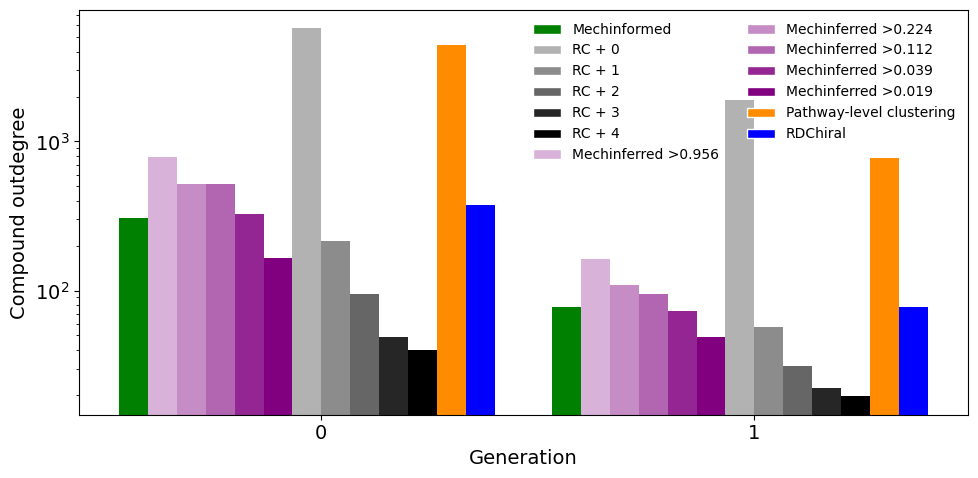

In [11]:
# Fan out clustered bar graph

gens = cpd_df.gen.unique()
scl_space = 1.5
n_bars = len(exp_labels)
width = 0.1

fig, ax = plt.subplots(figsize=(10, 5))

for gen in gens:
    ctr = gen * scl_space
    for i in range(n_bars):
        tick = ctr - ((n_bars * width) / 2) + (i * width)
        exp_name = exp_names[i]
        mean_fan_out = cpd_df.loc[(cpd_df["gen"] == gen) & (cpd_df["expansion"] == exp_name), "fan_out"]["mean"].values[0]
        label = exp_labels[exp_name]
        color = colors[exp_name]
        ax.bar(tick, height=mean_fan_out, width=width, color=color, label=label)
ax.set_xticks(gens * scl_space)
ax.set_xticklabels(gens.astype(int))
ax.set_yscale('log')
ax.set_xlabel("Generation")
ax.set_ylabel("Compound outdegree")
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_fan_out_clustered_bar_graph.svg", format="svg")
plt.show()
        

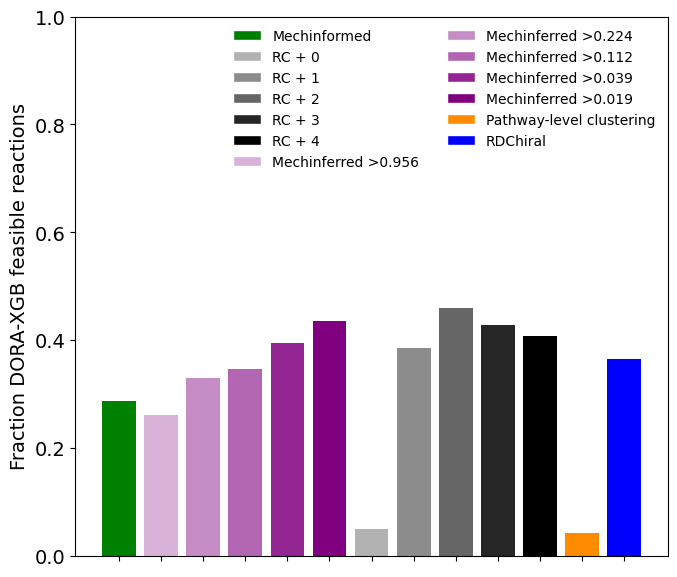

In [12]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Fraction DORA-XGB feasible reactions")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_feasibility_bar_graph.svg", format="svg")
plt.show()

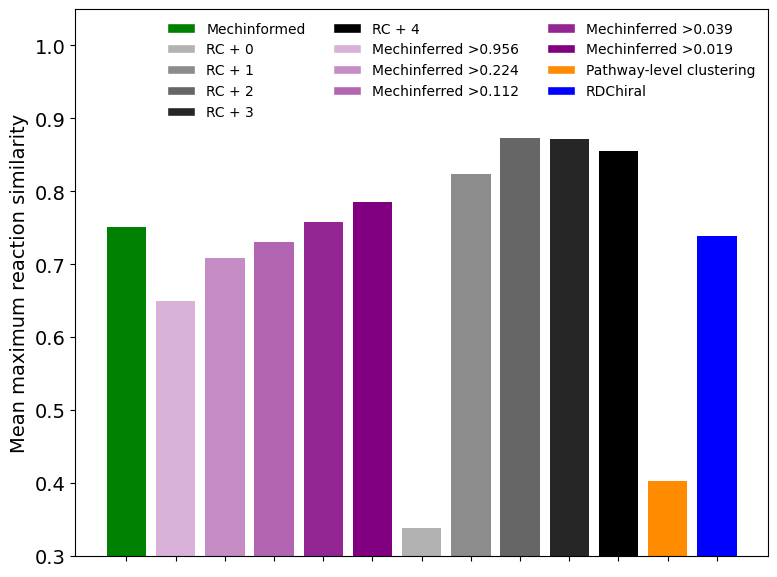

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.8
for exp_name in exp_names:
    mean = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.bar(x=exp_name, height=mean, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=3, frameon=False, fontsize=10)
ax.set_ylim(0.3, 1.05)
ax.set_ylabel("Mean maximum reaction similarity")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_bar_graph.svg", format="svg")
plt.show()

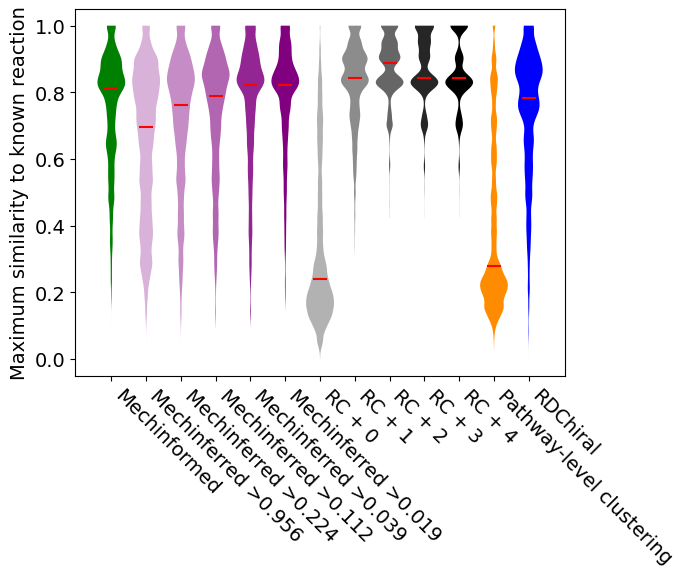

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
data = []
xticklabels = []
positions = []
_colors = []
_alphas = []
for i, exp_name in enumerate(exp_names):
    data.append(rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"])
    xticklabels.append(exp_labels[exp_name])
    positions.append(i)
    _colors.append(tuple(elt for elt in colors[exp_name][:-1]))
    _alphas.append(colors[exp_name][-1])  # store alpha for violin plot

vparts = ax.violinplot(data, positions=positions, widths=width, showmeans=False, showmedians=True, showextrema=False)

for color, alpha, vp in zip(_colors, _alphas, vparts['bodies']):
    vp.set_facecolor(color)
    # vp.set_edgecolor('black')
    vp.set_alpha(alpha)

vparts["cmedians"].set_color("red")

ax.set_xticks(positions)
ax.set_xticklabels(labels=xticklabels, rotation=-45, ha='left')
ax.set_ylim(-0.05, 1.05)
ax.set_ylabel("Maximum similarity to known reaction")
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_max_rxn_sim_violin_plot.svg", format="svg")
plt.show()

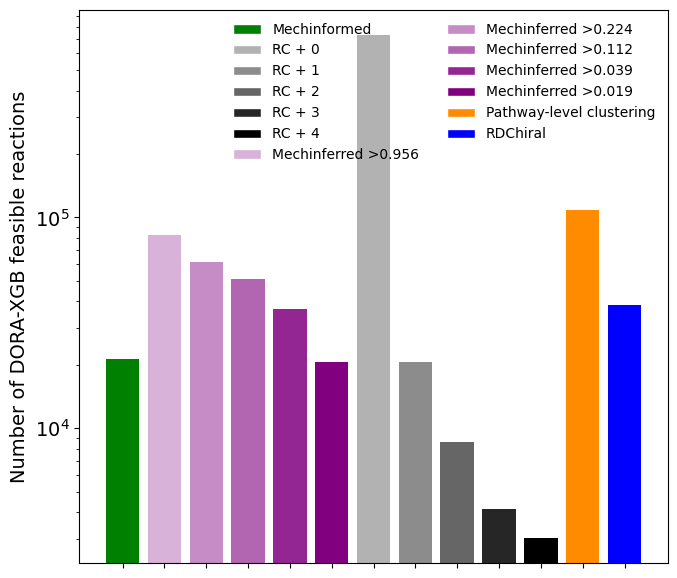

In [15]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=feas_frac * tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Number of DORA-XGB feasible reactions")
ax.set_yscale('log')
plt.tight_layout()
plt.show()

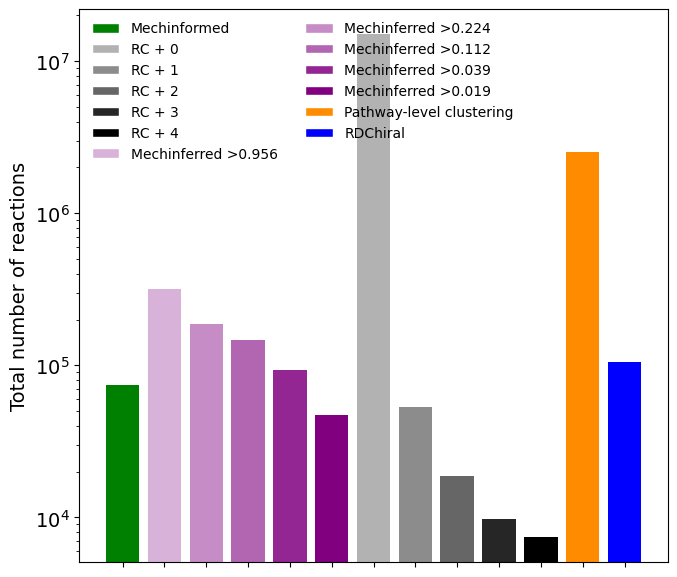

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    color = colors[exp_name]
    ax.bar(x=exp_name, height=tot_rxns, width=width, color=color)

ax.set_xticklabels(labels=[])
ax.legend(handles=legend_elements, loc='upper left', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_bar_graph.svg", format="svg")
plt.show()

Mechinferred fit: [-4.64920938  6.75902057]
RC+ fit: [-7.89901875  7.53363663]


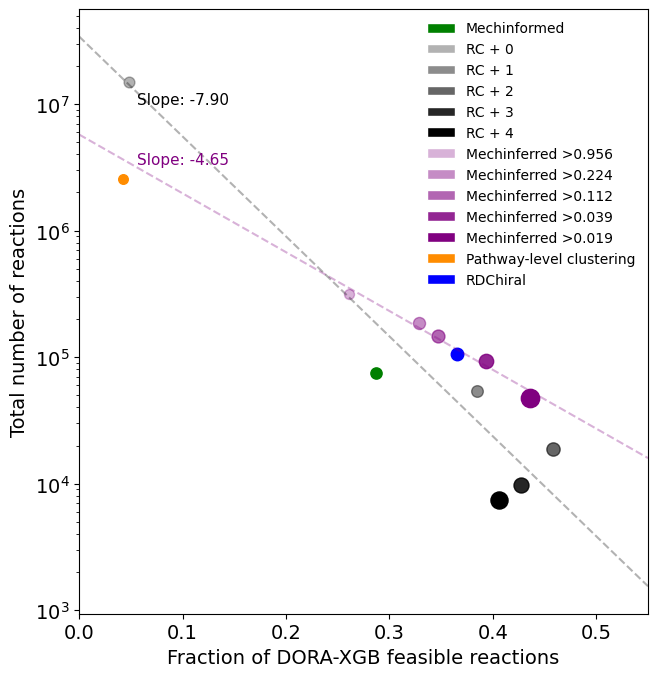

In [34]:
mechinferred_points = []
rcplus_points = []
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    
    if "mechinferred" in exp_name:
        mechinferred_points.append((feas_frac, tot_rxns))

    if "rc_plus" in exp_name:
        rcplus_points.append((feas_frac, tot_rxns))

# Fit lines to the points
mechinferred_points = np.array(mechinferred_points)
rcplus_points = np.array(rcplus_points)

mechinferred_fit = np.polyfit(mechinferred_points[:, 0], np.log10(mechinferred_points[:, 1]), 1)
rcplus_fit = np.polyfit(rcplus_points[:, 0], np.log10(rcplus_points[:, 1]), 1)
print("Mechinferred fit:", mechinferred_fit)
print("RC+ fit:", rcplus_fit)

fig, ax = plt.subplots(figsize=(6.8, 7))
width = 0.8
xmin = 0
xmax = 0.55
dot_slope = 0.3
dot_intercept = 6

for exp_name in exp_names:
    abbrev = f"{exp_name.split("_rules_")[1]}_rules"
    template_size = template_sizes.loc[template_sizes["name"] == abbrev, "median"].values[0]
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = rxn_df.loc[rxn_df["expansion"] == exp_name, "dxgb_label"].mean()
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color, markersize=dot_intercept + dot_slope * template_size)

    if feas_frac < xmin:
        xmin = feas_frac
    if feas_frac > xmax:
        xmax = feas_frac

xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, line_of_best_fit(xrange, mechinferred_fit), color=matplotlib.colors.to_rgba("purple", alpha=0.3), linestyle="--", label="Mechinferred fit")
ax.plot(xrange, line_of_best_fit(xrange, rcplus_fit), color=matplotlib.colors.to_rgba("black", alpha=0.3), linestyle="--", label="RC + n fit")

# Add slope labels to the fitted lines
mechinferred_slope = mechinferred_fit[0]
rcplus_slope = rcplus_fit[0]
label_idx = 10

ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], mechinferred_fit),
    f"Slope: {mechinferred_slope:.2f}", color=matplotlib.colors.to_rgba("purple", alpha=1.0),
    va='bottom', ha='left', fontsize=11
)
ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], rcplus_fit),
    f"Slope: {rcplus_slope:.2f}", color=matplotlib.colors.to_rgba("black", alpha=1.0),
    va='top', ha='left', fontsize=11
)
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
ax.set_xlim(xmin, xmax)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_feasibility.svg", format="svg")
plt.show()

Mechinferred fit: [-4.62371533  7.23265349]
RC+ fit: [-6.9871391   8.22933675]


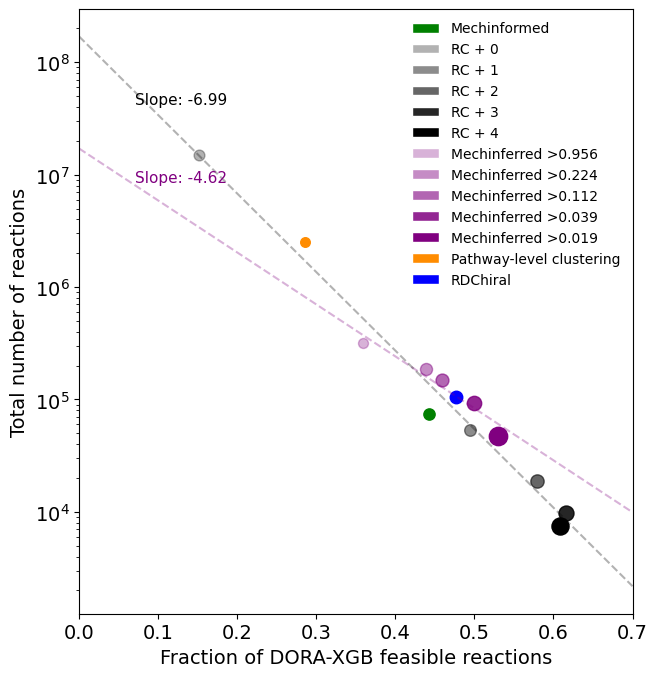

: 

In [ ]:
mechinferred_points = []
rcplus_points = []
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = ave_by_rule.loc[ave_by_rule["expansion"] == exp_name, 'dxgb_frac'].values[0]
    
    if "mechinferred" in exp_name:
        mechinferred_points.append((feas_frac, tot_rxns))

    if "rc_plus" in exp_name:
        rcplus_points.append((feas_frac, tot_rxns))

# Fit lines to the points
mechinferred_points = np.array(mechinferred_points)
rcplus_points = np.array(rcplus_points)

mechinferred_fit = np.polyfit(mechinferred_points[:, 0], np.log10(mechinferred_points[:, 1]), 1)
rcplus_fit = np.polyfit(rcplus_points[:, 0], np.log10(rcplus_points[:, 1]), 1)
print("Mechinferred fit:", mechinferred_fit)
print("RC+ fit:", rcplus_fit)

fig, ax = plt.subplots(figsize=(6.8, 7))
width = 0.8
xmin = 0
xmax = 0.7
dot_slope = 0.3
dot_intercept = 6

for exp_name in exp_names:
    abbrev = f"{exp_name.split("_rules_")[1]}_rules"
    template_size = template_sizes.loc[template_sizes["name"] == abbrev, "median"].values[0]
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    feas_frac = ave_by_rule.loc[ave_by_rule["expansion"] == exp_name, 'dxgb_frac'].values[0]
    color = colors[exp_name]
    ax.plot(feas_frac, tot_rxns, marker='o', color=color, markersize=dot_intercept + dot_slope * template_size)

    if feas_frac < xmin:
        xmin = feas_frac
    if feas_frac > xmax:
        xmax = feas_frac

xrange = np.linspace(xmin, xmax, 100)
ax.plot(xrange, line_of_best_fit(xrange, mechinferred_fit), color=matplotlib.colors.to_rgba("purple", alpha=0.3), linestyle="--", label="Mechinferred fit")
ax.plot(xrange, line_of_best_fit(xrange, rcplus_fit), color=matplotlib.colors.to_rgba("black", alpha=0.3), linestyle="--", label="RC + n fit")

# Add slope labels to the fitted lines
mechinferred_slope = mechinferred_fit[0]
rcplus_slope = rcplus_fit[0]
label_idx = 10

ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], mechinferred_fit),
    f"Slope: {mechinferred_slope:.2f}", color=matplotlib.colors.to_rgba("purple", alpha=1.0),
    va='bottom', ha='left', fontsize=11
)
ax.text(
    xrange[label_idx], line_of_best_fit(xrange[label_idx], rcplus_fit),
    f"Slope: {rcplus_slope:.2f}", color=matplotlib.colors.to_rgba("black", alpha=1.0),
    va='top', ha='left', fontsize=11
)
ax.legend(handles=legend_elements, loc='upper right', ncol=1, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Fraction of DORA-XGB feasible reactions")
ax.set_yscale('log')
ax.set_xlim(xmin, xmax)
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_rule_averaged_feasibility.svg", format="svg")
plt.show()

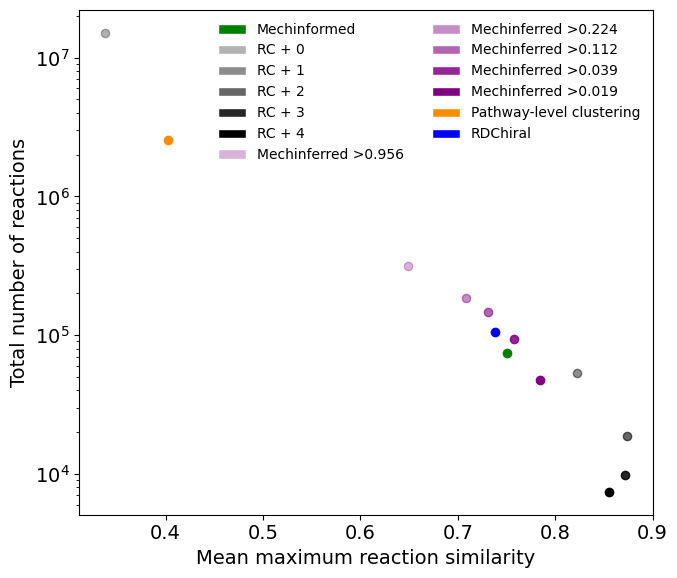

In [21]:
fig, ax = plt.subplots(figsize=(7, 6))
width = 0.8
for exp_name in exp_names:
    tot_rxns = ct_df.loc[ct_df["expansion"] == exp_name, "n_rxns"].values[0]
    mean_max_sim = rxn_df.loc[rxn_df["expansion"] == exp_name, "max_rxn_sim"].mean()
    color = colors[exp_name]
    ax.plot(mean_max_sim, tot_rxns, marker='o', color=color)

ax.legend(handles=legend_elements, loc='upper right', ncol=2, frameon=False, fontsize=10)
ax.set_ylabel("Total number of reactions")
ax.set_xlabel("Mean maximum reaction similarity")
ax.set_yscale('log')
plt.tight_layout()
fig.savefig(Path(cfg.figures) / f"{expansion_name}_total_reactions_vs_mean_max_rxn_sim.svg", format="svg")
plt.show()